## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/pedro/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/pedro/.fastai/data/camvid/labels'),
 PosixPath('/home/pedro/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/pedro/.fastai/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/pedro/.fastai/data/camvid/images/Seq05VD_f02010.png'),
 PosixPath('/home/pedro/.fastai/data/camvid/images/0016E5_01620.png'),
 PosixPath('/home/pedro/.fastai/data/camvid/images/0016E5_06300.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/pedro/.fastai/data/camvid/labels/Seq05VD_f03270_P.png'),
 PosixPath('/home/pedro/.fastai/data/camvid/labels/0016E5_08031_P.png'),
 PosixPath('/home/pedro/.fastai/data/camvid/labels/Seq05VD_f00690_P.png')]

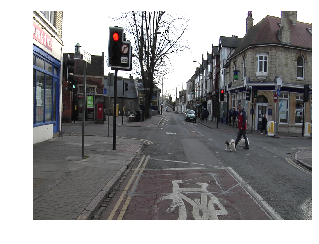

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
print(img_f, img_f.stem, img_f.suffix)

/home/pedro/.fastai/data/camvid/images/Seq05VD_f02010.png Seq05VD_f02010 .png


In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [11]:
get_y_fn(img_f)

PosixPath('/home/pedro/.fastai/data/camvid/labels/Seq05VD_f02010_P.png')

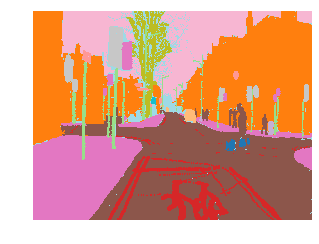

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [14]:
mask.shape

torch.Size([1, 720, 960])

In [15]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [16]:
size = src_size//2
bs=8

In [17]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [23]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

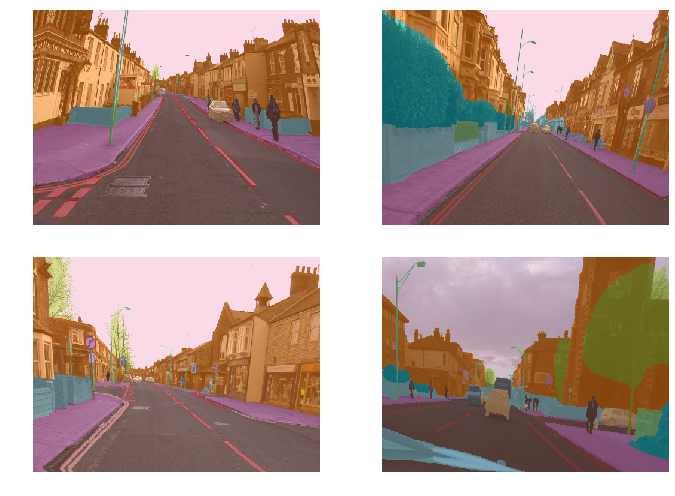

In [24]:
data.show_batch(2, figsize=(10,7))

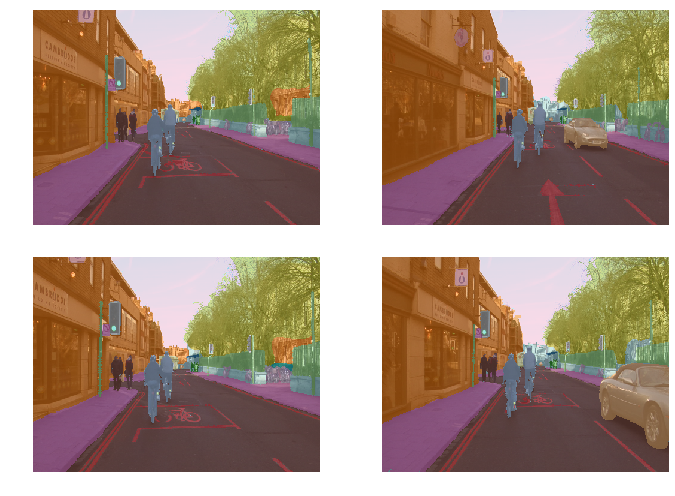

In [25]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [21]:
wd=1e-2

In [34]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04


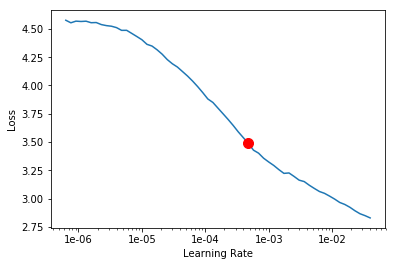

In [39]:
lr_find(learn)
learn.recorder.plot()

In [40]:
lr=3e-3

In [42]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.324431,0.864568,0.773037
2,0.865715,0.600605,0.844100
3,0.714487,0.638763,0.840268
4,0.657520,0.537184,0.862129
5,0.693374,0.607660,0.846956
6,0.611004,0.443533,0.886593
7,0.568132,0.533778,0.859738
8,0.602335,0.471639,0.881917
9,0.535793,0.466349,0.871069
10,0.462971,0.355479,0.903160


In [43]:
learn.save('stage-1')

In [44]:
learn.load('stage-1');

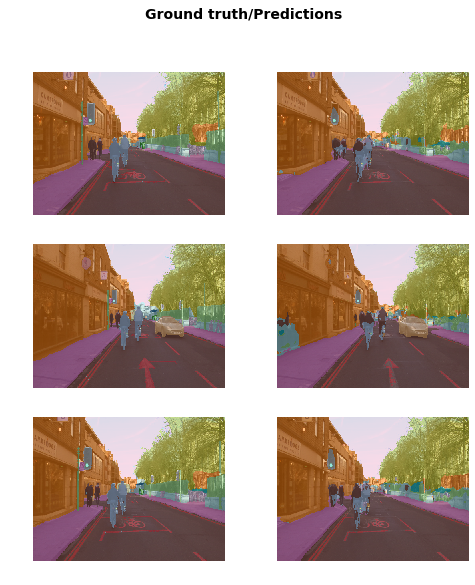

In [45]:
learn.show_results(rows=3, figsize=(8,9))

In [46]:
learn.unfreeze()

In [47]:
lrs = slice(lr/400,lr/4)

In [56]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.398249,0.351503,0.896743
2,0.389323,0.343508,0.897933
3,0.375867,0.332290,0.901848
4,0.367894,0.337258,0.901183
5,0.356964,0.314714,0.911714
6,0.347950,0.318146,0.907426
7,0.335506,0.343432,0.903057
8,0.328565,0.304016,0.909477
9,0.327587,0.318963,0.909918
10,0.318975,0.319519,0.909256


In [61]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [42]:
torch.cuda.empty_cache()

In [24]:
size = src_size
bs=2

In [25]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [26]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [46]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04


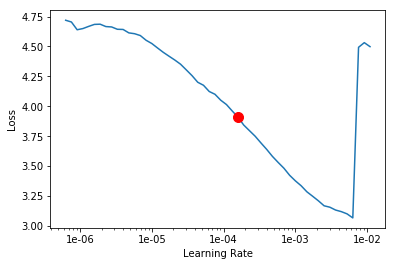

In [47]:
lr_find(learn)
learn.recorder.plot()

In [30]:
lr=1e-3

In [49]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.889847,0.650916,0.838285
2,0.680253,0.710242,0.795145
3,0.635540,0.509238,0.854845
4,0.624570,0.521503,0.862071
5,0.591030,0.453970,0.884447
6,0.507719,0.418777,0.886661
7,0.495582,0.388948,0.892250
8,0.474040,0.370125,0.899774
9,0.371596,0.286522,0.919565
10,0.320520,0.274486,0.920520


In [50]:
learn.save('stage-1-big')

## Replicate with half-float precision

In [41]:
torch.cuda.empty_cache()

In [46]:
size = src_size
bs=3     # It was 2 before (for the big model)

In [47]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [48]:
learn = unet_learner(data, models.resnet34, metrics=metrics).to_fp16()    # to_fp16()

/home/pedro/code/fast.ai/env/lib/python3.7/site-packages/fastai/callbacks/fp16.py:97: UserWarning: You have a `loss_scale` factor that is too high, try to divide it by 2 (current value: 512).
  warn(f"You have a `loss_scale` factor that is too high, try to divide it by 2 (current value: {self.loss_scale}).")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04


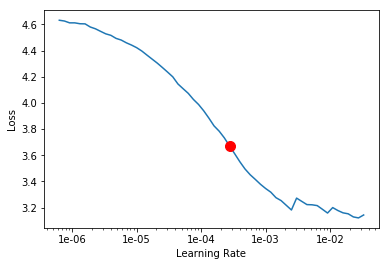

In [49]:
lr_find(learn)
learn.recorder.plot()

In [50]:
lr=1e-3

In [51]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.953018,0.766320,0.812386
2,0.724257,0.508933,0.859860
3,0.647516,0.429755,0.885077
4,0.603375,0.442225,0.887975
5,0.587508,0.472028,0.872760
6,0.521582,0.432087,0.889179
7,0.524331,0.349984,0.904189
8,0.492699,0.420650,0.884692
9,0.418151,0.307611,0.918586
10,0.315848,0.276792,0.921228


In [52]:
learn.save('stage-1-big-fp16')

### Stop the kernel here

In [63]:
torch.cuda.empty_cache()

In [27]:
learn = learn.load('stage-1-big')

In [28]:
learn.unfreeze()

In [31]:
lrs = slice(1e-6,lr/10)

In [32]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.294528,0.269138,0.921989
2,0.286718,0.270516,0.923568
3,0.286148,0.273316,0.921360
4,0.282647,0.256978,0.928157
5,0.251589,0.266801,0.923983
6,0.260398,0.253947,0.927189
7,0.247479,0.259909,0.925173
8,0.243038,0.252325,0.926615
9,0.224652,0.256712,0.926446
10,0.237557,0.250407,0.927715


In [33]:
learn.save('stage-2-big')

In [34]:
learn.load('stage-2-big');

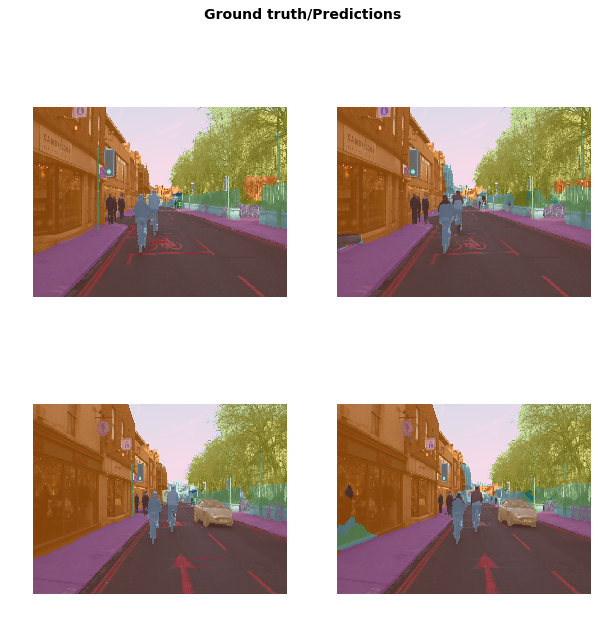

In [35]:
learn.show_results(rows=3, figsize=(10,10))

## fin